# Support for the JSON data format after GSoC 2020

> Created: 2020-11-23

The [Google Summer of Code (GSoC) 2020](https://summerofcode.withgoogle.com/)
is over and I had the pleasure to mentor
[Abdallah Elshamy](https://abdallahshamy.wordpress.com/),
who enriched Octave with the `jsondecode()` and `jsonencode()` functions.
A remaining issue was the translation of the Octave function
[`matlab.lang.makeValidName`](https://www.octave.org/doc/v5.2.0/XREFmatlab_005flang_005fmakeValidName.html)
to the C++ language.
This is now accomplished and the overall results are great.

> See [the previous benchmark of this Jupyter Notebook](../../../2020/08/19/gsoc2020-json-benchmark.ipynb)
> (August 19, 2020) with `matlab.lang.makeValidName` as Octave code.

Again a larger JSON data set was used,
with test cases collected from the excellent
[nativejson-benchmark](https://github.com/miloyip/nativejson-benchmark),
but with focus on Octave.

Only the running times for reading and writing JSON data
are regarded in this benchmark.
Another
[test by Abdallah](https://lists.gnu.org/archive/html/octave-maintainers/2020-06/msg00112.html)
has been carried out in June to test the compatibility for Matlab.

The test environment is a laptop with
- [Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz](https://ark.intel.com/content/www/us/en/ark/products/193563/intel-core-i7-8665u-processor-8m-cache-up-to-4-80-ghz.html)
- 16 GB of main memory
- OpenSUSE 15.2 Linux
- [JupyterLab](https://github.com/siko1056/jupyterlab-runner)
- Octave version as given below

In [1]:
octave_version = version ()
octave_hg_id   = version ('-hgid')

octave_version = 7.0.0
octave_hg_id = 38e22065d9ec


The following JSON extensions for Octave are under test.

| name | description |
| --- | --- |
| [Octave (builtin)](https://abdallahshamy.wordpress.com/) | Based on [RapidJSON](https://rapidjson.org/), reading DOM API. |
| [octave-rapidjson](https://github.com/Andy1978/octave-rapidjson) | Based on [RapidJSON](https://rapidjson.org/), reading SAX API. |
| [octave-jsonstuff](https://github.com/apjanke/octave-jsonstuff) | Based on [RapidJSON](https://rapidjson.org/), reading DOM API, writing m-file. |
| [JSONio](https://github.com/gllmflndn/JSONio) | Based on [JSMN](https://zserge.com/jsmn/), writing m-file. |
| [jsonlab](https://github.com/fangq/jsonlab) | m-file only |



The JSON test files are described in the following table.

| name | size (byte) | description |
| --- | --: | --- |
| [citm_catalog.json](https://github.com/RichardHightower/json-parsers-benchmark/blob/master/data/citm_catalog.json) | 1,727,204 | Structured data with mixed text and numeric. |
| [canada.json](https://github.com/mloskot/json_benchmark/blob/master/data/canada.json) | 2,251,060 | Numeric data set in [GeoJSON](https://en.wikipedia.org/wiki/GeoJSONhttps://en.wikipedia.org/wiki/GeoJSON) format. |
| [large-file.json](https://github.com/json-iterator/test-data/blob/master/large-file.json) | 26,141,343 | Structured data with mixed text and numeric. |

## Benchmark setup

Create a directory to keep track of the mess.

In [2]:
mkdir ('benchmark');
cd ('benchmark');

Load the benchmark JSON files.

In [3]:
if (exist ('citm_catalog.json', 'file') ~= 2)
  urlwrite ( ...
    'https://github.com/RichardHightower/json-parsers-benchmark/raw/master/data/citm_catalog.json', ...
    'citm_catalog.json');
end

if (exist ('canada.json', 'file') ~= 2)
  urlwrite ( ...
    'https://github.com/mloskot/json_benchmark/raw/master/data/canada.json', ...
    'canada.json');
end

if (exist ('large-file.json', 'file') ~= 2)
  urlwrite ( ...
    'https://github.com/json-iterator/test-data/raw/master/large-file.json', ...
    'large-file.json');
end

Setup **octave-rapidjson**.

In [4]:
if (exist ('octave-rapidjson', 'dir') == 0)
  urlwrite ( ...
    'https://github.com/Andy1978/octave-rapidjson/archive/2d88511712032b14dea4c2272d82249e7547772a.zip', ...
    'octave-rapidjson.zip');
  unzip  ('octave-rapidjson.zip');
  rename ('octave-rapidjson-2d88511712032b14dea4c2272d82249e7547772a', ...
          'octave-rapidjson');
  cd ('octave-rapidjson')
  urlwrite ( ...
    'https://github.com/Tencent/rapidjson/archive/35e480fc4ddf4ec4f7ad34d96353eef0aabf002d.zip', ...
    'rapidjson.zip');
  unzip  ('rapidjson.zip');
  rename ('rapidjson-35e480fc4ddf4ec4f7ad34d96353eef0aabf002d', 'rapidjson');
  mkoctfile -Wall -Wextra -I./rapidjson/include load_json.cc
  mkoctfile -Wall -Wextra -I./rapidjson/include save_json.cc
  cd ('..')
end

Setup **octave-jsonstuff**.

In [5]:
if (isempty (pkg ('list', 'jsonstuff')))
  pkg install https://github.com/apjanke/octave-jsonstuff/releases/download/v0.3.3/jsonstuff-0.3.3.tar.gz
end

Setup **JSONio**.

In [6]:
if (exist ('JSONio', 'dir') == 0)
  urlwrite ( ...
    'https://github.com/gllmflndn/JSONio/archive/6c699a315ac2c578864d8b740a061bff47b718bf.zip', ...
    'JSONio.zip');
  unzip  ('JSONio.zip');
  rename ('JSONio-6c699a315ac2c578864d8b740a061bff47b718bf', 'JSONio');
  cd ('JSONio')
  mkoctfile --mex jsonread.c jsmn.c -DJSMN_PARENT_LINKS
  cd ('..')
end

Setup **jsonlab**.

In [7]:
if (exist ('jsonlab', 'dir') == 0)
  urlwrite ( ...
    'https://github.com/fangq/jsonlab/archive/d0fb684bd43165d312063345bdb795b628b2c679.zip', ...
    'jsonlab.zip');
  unzip  ('jsonlab.zip');
  rename ('jsonlab-d0fb684bd43165d312063345bdb795b628b2c679', 'jsonlab');
end

## Benchmark run

The benchmark function reads the respective JSON file into a string
and calls the libraries reading and writing function.

In [8]:
function t = benchmark (json_read_fcn, json_write_fcn)
  test_files = {'citm_catalog.json', 'canada.json', 'large-file.json'};
  N = length (test_files);
  t = nan (N, 2);
  for i = 1:N
    json_str = fileread (test_files{i});
    tic ();
    octave_obj = json_read_fcn (json_str);
    t(i,1) = toc ();
    tic ();
    json_str2 = json_write_fcn (octave_obj);
    t(i,2) = toc ();
  end
end

The results for the **Matlab (R2020b, prerelease)** have been measured
on the same system without JupyterLab.

In [9]:
t.matlab = [
  0.0768, 0.0853;
  0.1510, 0.5405;
  1.2222, 0.6521];

**Octave (7.0.0, development version)**

In [10]:
t.octave = benchmark (@jsondecode, @jsonencode);

**octave-rapidjson**

In [11]:
addpath ('octave-rapidjson')
t.rapid_json = benchmark (@load_json, @save_json);
rmpath ('octave-rapidjson')

**octave-jsonstuff**: No results due to an error.

In [12]:
%pkg load jsonstuff
%t.jsonstuff = benchmark (@jsondecode, @jsonencode);
%error: cat: field names mismatch in concatenating structs
%error: called from
%    jsondecode>condense_decoded_json_recursive at line 116 column 9
%    jsondecode>condense_decoded_json at line 67 column 7
%    jsondecode at line 63 column 7
%    benchmark at line 8 column 16
%pkg unload jsonstuff

**JSONio**: Because of the long running time, the results of the first run
are saved here.

In [13]:
addpath ('JSONio')
%t.jsonio = benchmark (@jsonread, @jsonwrite);
t.jsonio = [ ...
  0.9583,  30.5410;
  6.1333,  17.4022;
  4.3382, 552.8929];
rmpath ('JSONio')

**Jsonlab**: Because of the long running time, the results of the first run
are saved here.

In [14]:
addpath ('jsonlab')
%t.jsonlab = benchmark (@loadjson, @savejson);
t.jsonlab = [ ...
   35.6242,  26.0625;
    6.1303,   0.7365;
  372.2456, 601.5318];
rmpath ('jsonlab')

## Benchmark results

In [15]:
graphics_toolkit ('qt')
titles = {'citm\_catalog.json (2 MB, mixed)', ...
          'canada.json (2 MB, numeric)', ...
          'large-file.json (26 MB, mixed)'};

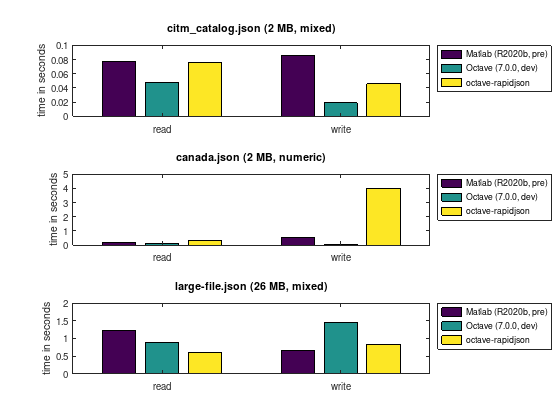

In [16]:
for i = 1:3
  subplot (3, 1, i);
  bar ([t.matlab(i,:); t.octave(i,:); t.rapid_json(i,:)]');
  legend ({'Matlab (R2020b, pre)', 'Octave (7.0.0, dev)', ...
           'octave-rapidjson'}, 'Location', 'bestoutside');
  xticklabels({'read','write'});
  ylabel ('time in seconds');
  title (titles{i});
end

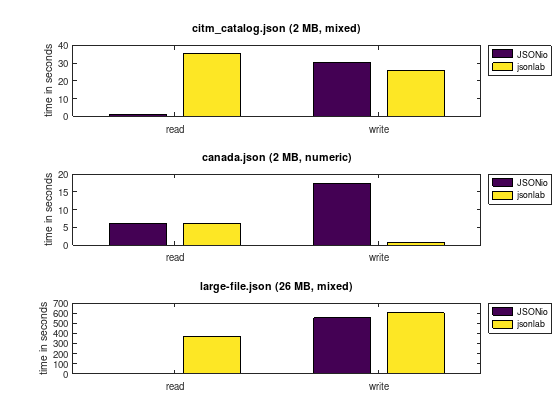

In [17]:
for i = 1:3
  subplot (3, 1, i);
  bar ([t.jsonio(i,:); t.jsonlab(i,:)]');
  legend ({'JSONio', 'jsonlab'}, 'Location', 'bestoutside');
  xticklabels({'read','write'});
  ylabel ('time in seconds');
  title (titles{i});
end

The first figure compares the running times of **Matlab**, **Octave**, and
**octave-rapidjson**.
Both **Octave** and **octave-rapidjson** are based on RapidJSON
and perform in many cases better than the Matlab implementation.

**octave-rapidjson** is using the **SAX API** of RapidJSON,
while the **new Octave implementation** uses the **DOM API**.
This decision was made to achieve best compatibility to Matlab,
which was in some cases difficult with the SAX API
and is no pririty for the octave-rapidjson project.
The results show,
that both APIs perform similarly in the tested data sets,
even though there is a claim,
that [the SAX API is faster](https://rapidjson.org/md_doc_faq.html#autotoc_md70)
in some cases.

The results of **JSONio** and **jsonlab** are split into a second figure,
as the running times are significantly larger than those of the first figure.
For **octave-jsonstuff** we could due to an error not obtain any results
and the [maintainer is informed](https://github.com/apjanke/octave-jsonstuff/issues/21)
about it.